In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
train = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/test.csv')
print(len(train), len(test))
train.head(10)

36765 10


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective


In [3]:
submission = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/sample_submission.csv')
submission.head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47


In [4]:
train['essay_id'].describe()

count            36765
unique            4191
top       91B1F82B2CF1
freq                23
Name: essay_id, dtype: object

We have 4191 unique essays which form the corpus of our work and which the discourse texts are gotten from

In [5]:
train['discourse_effectiveness'].value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

In [6]:
fig = px.pie(train, names='discourse_effectiveness', width=600, title='Discourse effectiveness')
fig.update_layout(plot_bgcolor='#53354A')
fig.show()

We see that we have more of "adequate" arguments than of the other effectiveness score - Effective and Ineffective.

In [7]:
train['discourse_type'].value_counts()

Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: discourse_type, dtype: int64

In [8]:
fig = px.histogram(train, x='discourse_type', width=1000, title='discourse_type')
fig.show()

We can see the distribution of Discourse types in the dataset as above.

In [9]:
train.loc[0, 'discourse_text']

"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. "

We have to combine the text data with the dataframe we have on there.

In [10]:
def trainessay_paraphrase(x):
    with open(f"/kaggle/input/feedback-prize-effectiveness/train/{x}.txt") as f:
        content = f.readline()
    return content


train['essay'] = train['essay_id'].apply(trainessay_paraphrase)
train.drop('essay_id', axis=1, inplace=True)

In [11]:
train.head(10)

,discourse_id,discourse_text,discourse_type,discourse_effectiveness,essay
0,0013cc385424,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
5,36a565e45db7,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective,"Hi, i'm Isaac, i'm going to be writing about h..."
6,fb65fe816ba3,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
7,4e472e2584fa,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
8,28a94d3ee425,Though people were not satified about how the ...,Concluding Statement,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
9,d226f06362f5,Limiting the usage of cars has personal and pr...,Lead,Effective,Limiting the usage of cars has personal and pr...


In [12]:
# let's do the same for the test dataset

def testessay_paraphrase(x):
    with open(f"/kaggle/input/feedback-prize-effectiveness/test/{x}.txt") as f:
        content = f.readline()
    return content


test['essay'] = test['essay_id'].apply(testessay_paraphrase)
test.drop('essay_id', axis=1, inplace=True)

## Feature Engineering

Let's encode the discourse_type feature. For this one, we'll use the OneHotEncoder encoding

Let's encode the target column - `discourse_effectiveness`

In [13]:
train['discourse_effectiveness'].value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['discourse_effectiveness'])

train['discourse_effectiveness'] = encoder.transform(train['discourse_effectiveness'])

In [15]:
train['discourse_effectiveness'].value_counts()

0    20977
1     9326
2     6462
Name: discourse_effectiveness, dtype: int64

So we have `Adeequate` = 0, `Effective` = 1 and `Ineffective` = 2

In [16]:
train.shape, test.shape

((36765, 5), (10, 4))

In [17]:
train.head()

,discourse_id,discourse_text,discourse_type,discourse_effectiveness,essay
0,0013cc385424,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,0,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,"On my perspective, I think that the face is a ...",Position,0,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,I think that the face is a natural landform be...,Claim,0,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,"If life was on Mars, we would know by now. The...",Evidence,0,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,People thought that the face was formed by ali...,Counterclaim,0,"Hi, i'm Isaac, i'm going to be writing about h..."


## ML Model

Credit to [this notebook](https://www.kaggle.com/code/venkatkumar001/nlpstarter4-distilbert-bert-base-cased) for the helpful resource with using huggingface transfomer with the dataset

In [18]:
import transformers

from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TFBertModel

2023-01-04 20:33:13.662420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 20:33:13.663532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 20:33:13.664210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 20:33:13.666225: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
# cleanup some text
import re

def cleanup(text):
    words = re.sub(pattern = '[^a-zA-Z]',repl = ' ', string = text)
    words = words.lower()
    return words

train['discourse_text'] = train['discourse_text'].apply(cleanup)
train['essay'] = train['essay'].apply(cleanup)

In [20]:
train.head()

,discourse_id,discourse_text,discourse_type,discourse_effectiveness,essay
0,0013cc385424,hi i m isaac i m going to be writing about h...,Lead,0,hi i m isaac i m going to be writing about h...
1,9704a709b505,on my perspective i think that the face is a ...,Position,0,hi i m isaac i m going to be writing about h...
2,c22adee811b6,i think that the face is a natural landform be...,Claim,0,hi i m isaac i m going to be writing about h...
3,a10d361e54e4,if life was on mars we would know by now the...,Evidence,0,hi i m isaac i m going to be writing about h...
4,db3e453ec4e2,people thought that the face was formed by ali...,Counterclaim,0,hi i m isaac i m going to be writing about h...


In [21]:
# load BERT tokenizer from huggingface

tokenizer = transformers.BertTokenizer.from_pretrained('/kaggle/input/huggingface-bert/bert-base-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [22]:
def encode(texts, tokenizer, maxlen):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length = maxlen, truncation = True, padding='max_length',
                         add_special_tokens = True)
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
        
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

In [23]:
sep = tokenizer.sep_token
sep

'[SEP]'

In [24]:
train['inputs'] = train['discourse_type'] + sep + train['discourse_text']
train.head()

,discourse_id,discourse_text,discourse_type,discourse_effectiveness,essay,inputs
0,0013cc385424,hi i m isaac i m going to be writing about h...,Lead,0,hi i m isaac i m going to be writing about h...,Lead[SEP]hi i m isaac i m going to be writin...
1,9704a709b505,on my perspective i think that the face is a ...,Position,0,hi i m isaac i m going to be writing about h...,Position[SEP]on my perspective i think that t...
2,c22adee811b6,i think that the face is a natural landform be...,Claim,0,hi i m isaac i m going to be writing about h...,Claim[SEP]i think that the face is a natural l...
3,a10d361e54e4,if life was on mars we would know by now the...,Evidence,0,hi i m isaac i m going to be writing about h...,Evidence[SEP]if life was on mars we would kno...
4,db3e453ec4e2,people thought that the face was formed by ali...,Counterclaim,0,hi i m isaac i m going to be writing about h...,Counterclaim[SEP]people thought that the face ...


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train['inputs'], train['discourse_effectiveness'], test_size=0.1, random_state=42)

In [26]:
len(X_train), len(X_valid)

(33088, 3677)

In [27]:
maxlen = 128

X_train = encode(X_train.astype(str), tokenizer, maxlen)
X_valid = encode(X_valid.astype(str), tokenizer, maxlen)

In [28]:
y_train = y_train.values
y_valid = y_valid.values

In [29]:
# use TF.Data to wrap dataset
batch_size = 20
buffer_size = 1000

train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat()
                 .shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE))

valid_dataset = (tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).repeat()
                .shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE))

In [30]:
# bert model
transformer_layer = (TFBertModel.from_pretrained('/kaggle/input/huggingface-bert/bert-base-cased'))

Some layers from the model checkpoint at /kaggle/input/huggingface-bert/bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /kaggle/input/huggingface-bert/bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [31]:
def build_model(bert_model, maxlen):
    input_ids = keras.Input(shape=(maxlen, ), dtype=tf.int32, name='input_ids')
    token_type_ids = keras.Input(shape=(maxlen, ), dtype=tf.int32, name = 'token_type_ids')
    attention_mask = keras.Input(shape=(maxlen, ), dtype=tf.int32, name='attention_mask')
    
    sequence_output = bert_model(input_ids, token_type_ids, attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    
    # instantiate dropout & dense layers
    dropout = keras.layers.Dropout(0.1)
    dense = keras.layers.Dense(3, activation='softmax')
    
    # use them
    clf_output = dropout(clf_output)
    out = dense(clf_output)
    
    model = keras.models.Model(inputs = [input_ids, token_type_ids, attention_mask], outputs = out)
    return model

In [32]:
model = build_model(transformer_layer, maxlen)

In [33]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 token_type_ids[0][0]         

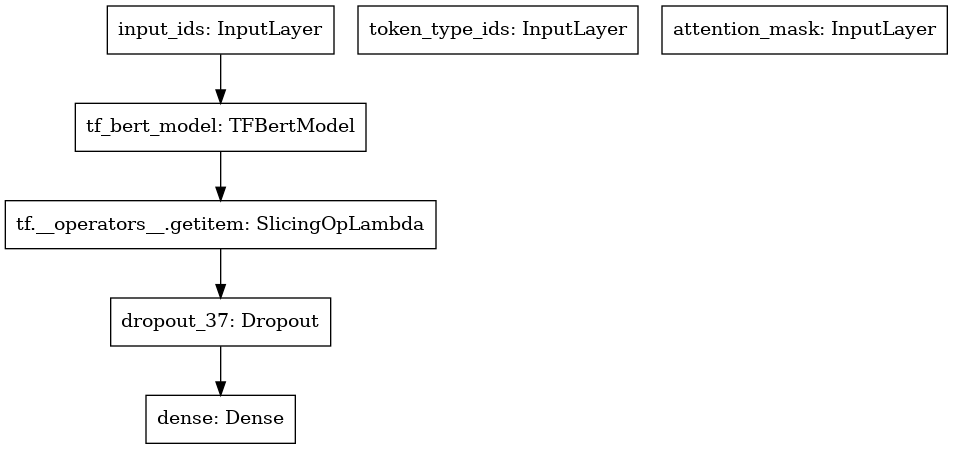

In [35]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [36]:
history = model.fit(train_dataset, steps_per_epoch=200, epochs=10, validation_data = valid_dataset, 
                    validation_steps = 200)

Epoch 1/10


2023-01-04 20:34:42.047083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


200/200 [==============================] - 110s 474ms/step - loss: 0.9182 - accuracy: 0.5913 - val_loss: 0.8808 - val_accuracy: 0.6330
Epoch 2/10
200/200 [==============================] - 92s 459ms/step - loss: 0.8535 - accuracy: 0.6122 - val_loss: 0.8600 - val_accuracy: 0.5940
Epoch 3/10
200/200 [==============================] - 92s 459ms/step - loss: 0.8107 - accuracy: 0.6390 - val_loss: 0.7730 - val_accuracy: 0.6565
Epoch 4/10
200/200 [==============================] - 92s 459ms/step - loss: 0.8034 - accuracy: 0.6445 - val_loss: 0.7860 - val_accuracy: 0.6323
Epoch 5/10
200/200 [==============================] - 92s 460ms/step - loss: 0.7999 - accuracy: 0.6348 - val_loss: 0.7690 - val_accuracy: 0.6467
Epoch 6/10
200/200 [==============================] - 92s 460ms/step - loss: 0.7892 - accuracy: 0.6530 - val_loss: 0.7611 - val_accuracy: 0.6513
Epoch 7/10
200/200 [==============================] - 92s 459ms/step - loss: 0.7802 - accuracy: 0.6528 - val_loss: 0.7664 - val_accuracy: 0.

### Evaluation

In [37]:
# let's preprocess the test dataset

test['discourse_text'] = test['discourse_text'].apply(cleanup)
test['essay'] = test['essay'].apply(cleanup)

In [38]:
test['inputs'] = test['discourse_type'] + sep + test['discourse_text']
test.head()

,discourse_id,discourse_text,discourse_type,essay,inputs
0,a261b6e14276,making choices in life can be very difficult ...,Lead,making choices in life can be very difficult ...,Lead[SEP]making choices in life can be very di...
1,5a88900e7dc1,seeking multiple opinions can help a person ma...,Position,making choices in life can be very difficult ...,Position[SEP]seeking multiple opinions can hel...
2,9790d835736b,it can decrease stress levels,Claim,making choices in life can be very difficult ...,Claim[SEP]it can decrease stress levels
3,75ce6d68b67b,a great chance to learn something new,Claim,making choices in life can be very difficult ...,Claim[SEP]a great chance to learn something new
4,93578d946723,can be very helpful and beneficial,Claim,making choices in life can be very difficult ...,Claim[SEP]can be very helpful and beneficial


In [39]:
X_test = test['inputs']
X_test = encode(X_test.astype(str), tokenizer, maxlen)

In [40]:
preds = model.predict(X_test)
preds = preds.tolist()
preds

[[0.21399521827697754, 0.7691332697868347, 0.016871578991413116],
 [0.46814295649528503, 0.48805394768714905, 0.04380311816930771],
 [0.38388046622276306, 0.5799768567085266, 0.03614261746406555],
 [0.707897424697876, 0.15319858491420746, 0.13890400528907776],
 [0.6743507981300354, 0.23017872869968414, 0.09547051042318344],
 [0.2356996238231659, 0.7427732944488525, 0.02152707241475582],
 [0.17933350801467896, 0.8049639463424683, 0.015702562406659126],
 [0.31105270981788635, 0.6630435585975647, 0.025903696194291115],
 [0.35209017992019653, 0.6026340126991272, 0.045275744050741196],
 [0.15273000299930573, 0.8341788053512573, 0.013091261498630047]]

In [41]:
sample = pd.DataFrame(preds, columns = ['Adequate', 'Effective', 'Ineffective'])
discourse_ids = submission['discourse_id']
sample['discourse_id'] = discourse_ids

# reorder the columns
sample = sample.loc[:, ['discourse_id', 'Ineffective', 'Adequate', 'Effective']]
sample

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.016872,0.213995,0.769133
1,5a88900e7dc1,0.043803,0.468143,0.488054
2,9790d835736b,0.036143,0.383880,0.579977
3,75ce6d68b67b,0.138904,0.707897,0.153199
4,93578d946723,0.095471,0.674351,0.230179
5,2e214524dbe3,0.021527,0.235700,0.742773
6,84812fc2ab9f,0.015703,0.179334,0.804964
7,c668ff840720,0.025904,0.311053,0.663044
8,739a6d00f44a,0.045276,0.352090,0.602634
9,bcfae2c9a244,0.013091,0.152730,0.834179


In [42]:
sample.to_csv('submission.csv', index=False)